<a href="https://colab.research.google.com/github/TejaswaniVelugoti/Lumpy-Skin-Disease-Detection-/blob/main/Lumpy_Skin_Detection_Using_DenseNet169.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_dir = '/content/drive/MyDrive/Lumpy Skin Images Dataset'

datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}


Found 928 images belonging to 2 classes.
Found 102 images belonging to 2 classes.


In [ ]:
base_model = DenseNet169(weights=None, include_top=False, input_shape=(256, 256, 3))


base_model.load_weights('/content/drive/MyDrive/DenseNet-BC-169-32-no-top.h5')


base_model.trainable = False


In [ ]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.1),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(216,activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
opt = optimizers.Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 8, 8, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1664)              0         
                                                                 
 dense (Dense)               (None, 1024)              1704960   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 216)               110808    
                                                        

In [ ]:
batch_size = 32
epochs = 15

train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 29
validation_steps : 3


In [ ]:
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"


checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]

history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)


Epoch 1/15
29/29 [==============================] - ETA: 0s - loss: 0.2351 - accuracy: 0.9095
Epoch 1: val_accuracy improved from -inf to 0.94792, saving model to ./model_01-0.95.h5
29/29 [==============================] - 22s 753ms/step - loss: 0.2351 - accuracy: 0.9095 - val_loss: 0.1876 - val_accuracy: 0.9479
Epoch 2/15
29/29 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.9127
Epoch 2: val_accuracy did not improve from 0.94792
29/29 [==============================] - 20s 701ms/step - loss: 0.2232 - accuracy: 0.9127 - val_loss: 0.2116 - val_accuracy: 0.9167
Epoch 3/15
29/29 [==============================] - ETA: 0s - loss: 0.2067 - accuracy: 0.9267
Epoch 3: val_accuracy did not improve from 0.94792
29/29 [==============================] - 21s 714ms/step - loss: 0.2067 - accuracy: 0.9267 - val_loss: 0.2251 - val_accuracy: 0.9062
Epoch 4/15
29/29 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9235
Epoch 4: val_accuracy did not improve 

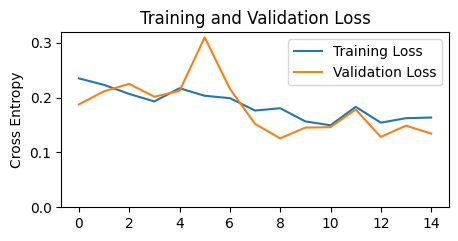

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()



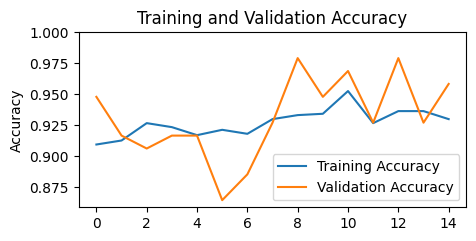

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)
print('test loss:',test_loss)

4/4 [==============================] - 1s 120ms/step - loss: 0.1426 - accuracy: 0.9510
test accuracy :  0.9509803652763367
test loss: 0.14255699515342712


In [ ]:
loaded_best_model = keras.models.load_model("/content/drive/MyDrive/model.h5")


def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0: 'Lumpy Skin', 1: 'Normal Skin'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))

    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

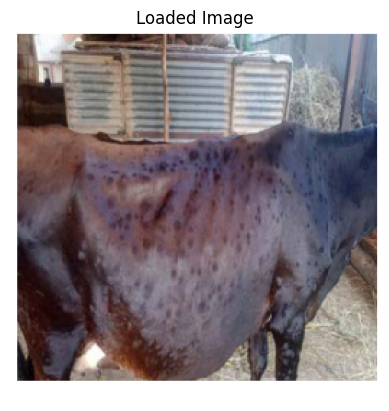

1/1 [==============================] - 9s 9s/step


Maximum Probability:  0.99842274
Classified: Lumpy Skin 



-------------------Individual Probability--------------------------------

LUMPY SKIN : 99.84 %
NORMAL SKIN : 0.16 %


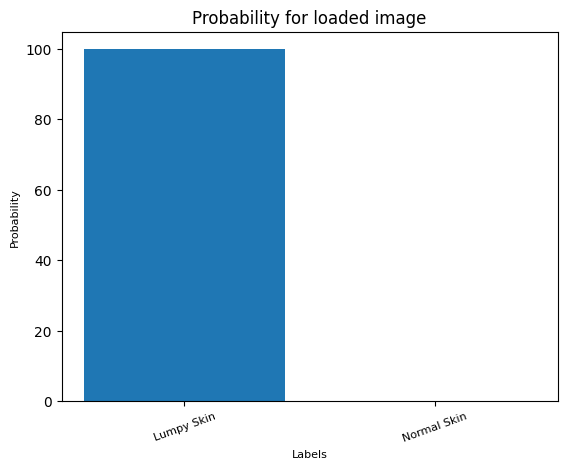

In [ ]:
predict('/content/drive/MyDrive/Screenshot 2023-12-29 001632.png')